# Exploration

In [132]:
import pandas as pd
import json
from pprint import pprint
from glob import glob
from os.path import join
from random import choice
from sklearn import metrics as m

Let's begin by grabbing all of the files in each directory and evaluating a random sample.

In [152]:
actuals = glob(join("data", "raw", "ground_truth", "*.json"))
predicted = glob(join("data", "raw", "predictions", "*.json"))
predicted[:4]

['data/raw/predictions/6105_dbbe9a43-d891-4b7a-b048-4adbae7b5c36_2022_01_06.json',
 'data/raw/predictions/7002_d259766e-d9bc-499e-8b54-a9e0eac33e92_2022_01_20.json',
 'data/raw/predictions/7002_d8c71f90-ddd5-42ac-b7cf-ab81d24f9916_2022_01_11.json',
 'data/raw/predictions/7002_7fba6770-f78d-4054-9643-45277523d7cd_2022_01_26.json']

In [153]:
random_sample = choice(actuals)
random_sample

'data/raw/ground_truth/7002_04fe0e08-ed2b-4fb6-bc8f-68174a83b5fb_2022_01_11.json'

Let's start by evaluating a sample.

In [147]:
with open(random_sample, "r") as sample:
    data = json.load(sample)
pprint(data)

{'annotations': [{'bounding_box': {'h': 127.0,
                                   'w': 368.0,
                                   'x': 2579.0,
                                   'y': 310.0},
                  'id': 'c0803b85-dcae-4379-bcc8-bd2a197e25a6',
                  'name': 'Alternaria spp.',
                  'slot_names': ['0']},
                 {'bounding_box': {'h': 324.0,
                                   'w': 204.0,
                                   'x': 208.0,
                                   'y': 1692.0},
                  'id': '9fdd7a8c-3595-4221-b93a-377d7734f500',
                  'name': 'Alternaria spp.',
                  'slot_names': ['0']}],
 'item': {'name': '6105_eec1e5b6-1a80-44a2-9f66-5f5e550ba9d4_2022_01_25.jpeg',
          'path': '/',
          'slots': [{'height': 3040,
                     'slot_name': '0',
                     'source_files': [{'file_name': '6105_eec1e5b6-1a80-44a2-9f66-5f5e550ba9d4_2022_01_25.jpeg',
                              

In [155]:
random_prediction = join("data", "raw", "predictions", random_sample.split("/")[-1])

with open(random_prediction, "r") as sample:
    data = json.load(sample)
pprint(data)

{'annotations': [{'bounding_box': {'h': 123.0,
                                   'w': 253.0,
                                   'x': 3655.0,
                                   'y': 609.0},
                  'id': '6adce333-cd9b-4545-9954-b2cd37ddd585',
                  'name': 'Alternaria spp.',
                  'slot_names': ['0']}],
 'item': {'name': '7002_04fe0e08-ed2b-4fb6-bc8f-68174a83b5fb_2022_01_11.jpeg',
          'path': '/',
          'slots': [{'height': 3040,
                     'slot_name': '0',
                     'source_files': [{'file_name': '7002_04fe0e08-ed2b-4fb6-bc8f-68174a83b5fb_2022_01_11.jpeg',
                                       'url': 'https://darwin.v7labs.com/api/v2/teams/bioscout/uploads/3e7f3272-c137-4be2-9518-270a772cc802'}],
                     'thumbnail_url': 'https://darwin.v7labs.com/api/v2/teams/bioscout/files/672c43cb-98b2-47d6-9b97-dc5419396e6e/thumbnail',
                     'type': 'image',
                     'width': 4064}],
       

If we go to the [`schema_ref` url](https://darwin-public.s3.eu-west-1.amazonaws.com/darwin_json_2_0.schema.json) that comes up in the JSON file above, we can find more information about the files we are dealing with. Nonetheless, while the classification task at hand is one with bounding boxes rather than **"yes"**, there are infectious spores in this sample, or **"no"**, there aren't any, we can still trea it as binary classification task by using the absence, or the lack thereof, the annotated boxes.

Let's see how many samples lack an annotation for one or more bounding boxex from the ground truth sample.

In [165]:
goods = 0
bads = 0
not_sure = 0
bad_plants = []

for file in actuals:
    with open(file, "r") as s:
        ac = json.load(s)
        if ac["annotations"]:
            goods += 1
        elif ac["annotations"] == []:
            bads += 1
            bad_plants.append(file)
        else:
            not_sure += 1
            bad_plants.append(file)
print(f"The ground truth sample has {goods} images with at least one instance of a decease, {bads} are healthy, and {not_sure} are unclear!")

The ground truth sample has 707 images with at least one instance of a decease, 45 are healthy, and 0 are unclear!


In [166]:
with open(choice(bad_plants), "r") as s:
    pprint(json.load(s))

{'annotations': [],
 'item': {'name': '6107_a611a543-a21d-4000-abfe-a2e958d007e2_2022_01_15.jpeg',
          'path': '/',
          'slots': [{'height': 3040,
                     'slot_name': '0',
                     'source_files': [{'file_name': '6107_a611a543-a21d-4000-abfe-a2e958d007e2_2022_01_15.jpeg',
                                       'url': 'https://darwin.v7labs.com/api/v2/teams/bioscout/uploads/d90c28aa-cce8-4732-9426-757134de9d62'}],
                     'thumbnail_url': 'https://darwin.v7labs.com/api/v2/teams/bioscout/files/2bb07fb6-9f42-4a43-9853-720bced8bfc6/thumbnail',
                     'type': 'image',
                     'width': 4064}],
          'source_info': {'dataset': {'dataset_management_url': 'https://darwin.v7labs.com/datasets/538883/dataset-management',
                                      'name': 'alternaria',
                                      'slug': 'alternaria'},
                          'item_id': '0183d477-6694-51ff-ca26-00c57c4d1136',
 

In [171]:
for file in bad_plants:
    with open(file, "r") as s:
        pprint(json.load(s)["annotations"])

Now that we know a bit about the files we're dealing with, let's create a few functions to programmatically extract, transform, load, and evaluate all of them.

Since we'll need to save files here and there throughout the steps, we'll start with a straightforward load function that takes in a dataframe and saves a parquet file.

In [192]:
def get_files(directory, regex_pattern):
    return glob(join(directory, regex_pattern))


def read_files(data_files: str) -> pd.DataFrame:
        
    dfs_list = []
    
    for file in data_files:    
        with open(file, "r") as sample:
            data = json.load(sample)

        item = data["item"]['name']

        if data["annotations"]:
            anno_name = data["annotations"][0]["name"]
        else:
            anno_name = "Undetected"
        
        df = pd.DataFrame(data=[[item, anno_name]], columns=["item_id", "class"])
        dfs_list.append(df)
    
    return pd.concat(dfs_list, axis=0)

Let's make sure our functions work.

In [193]:
actuals = get_files("data/raw/ground_truth/", "*.json")
actuals[:5]

['data/raw/ground_truth/6105_dbbe9a43-d891-4b7a-b048-4adbae7b5c36_2022_01_06.json',
 'data/raw/ground_truth/7002_d259766e-d9bc-499e-8b54-a9e0eac33e92_2022_01_20.json',
 'data/raw/ground_truth/7002_d8c71f90-ddd5-42ac-b7cf-ab81d24f9916_2022_01_11.json',
 'data/raw/ground_truth/7002_7fba6770-f78d-4054-9643-45277523d7cd_2022_01_26.json',
 'data/raw/ground_truth/6107_e475a371-228b-4e77-913b-38e0579d2837_2022_01_23.json']

In [194]:
read_files(actuals).head(10)

,item_id,class
0,6105_dbbe9a43-d891-4b7a-b048-4adbae7b5c36_2022...,Alternaria spp.
0,7002_d259766e-d9bc-499e-8b54-a9e0eac33e92_2022...,Alternaria spp.
0,7002_d8c71f90-ddd5-42ac-b7cf-ab81d24f9916_2022...,Alternaria spp.
0,7002_7fba6770-f78d-4054-9643-45277523d7cd_2022...,Alternaria spp.
0,6107_e475a371-228b-4e77-913b-38e0579d2837_2022...,Alternaria spp.
0,7002_44f7ae6c-27ff-4ea9-8ebf-7cf068161f69_2022...,Alternaria spp.
0,7002_ba67585b-8317-469c-b8eb-2f85b671fe53_2022...,Alternaria spp.
0,7002_cddf3cc2-2411-4cb1-9985-b5d3fef4c170_2022...,Undetected
0,6105_e5bbad9e-d694-4f2c-804c-b64072813055_2022...,Alternaria spp.
0,6105_5f2ab12b-22e6-4c31-90f8-605aab2663bf_2022...,Alternaria spp.


Excellent! We'll save the function in our src directory and start preparing a package in case we come up with new functions for extracting data, or in case we want to update our current ones.

In [ ]:
%%writefile src/etl/extract.py

import pandas as pd
from os.path import join
from glob import glob
from load import save_data

def get_files(directory, regex_pattern):
    return glob(join(directory, regex_pattern))


def read_files(data_files: str) -> pd.DataFrame:
        
    dfs_list = []
    
    for file in data_files:    
        with open(file, "r") as sample:
            data = json.load(sample)

        item = data["item"]['name']

        if data["annotations"]:
            anno_name = data["annotations"][0]["name"]
        else:
            anno_name = "Undetected"
        
        df = pd.DataFrame(data=[[item, anno_name]], columns=["item_id", "class"])
        dfs_list.append(df)
    
    return pd.concat(dfs_list, axis=0)

if __name__ == "__main__":
    files = get_files("data/raw/ground_truth/", "*.json")
    df = read_files(files)
    save_data()

In [49]:
first = []
second = []

for truth in actuals:
    first.append(read_file(truth))
    
for pred in predicted:
    second.append(read_file(pred))
    
df_true = build_df(first)
df_false = build_df(second)
df = pd.merge(left=df_true, right=df_false, left_on="item_id", right_on="item_id", suffixes=("_truth", "_pred"))
df.head()

,item_id,class_truth,class_pred
0,6105_dbbe9a43-d891-4b7a-b048-4adbae7b5c36_2022...,Alternaria spp.,Alternaria spp.
1,7002_d259766e-d9bc-499e-8b54-a9e0eac33e92_2022...,Alternaria spp.,Alternaria spp.
2,7002_d8c71f90-ddd5-42ac-b7cf-ab81d24f9916_2022...,Alternaria spp.,Alternaria spp.
3,7002_7fba6770-f78d-4054-9643-45277523d7cd_2022...,Alternaria spp.,Alternaria spp.
4,6107_e475a371-228b-4e77-913b-38e0579d2837_2022...,Alternaria spp.,Alternaria spp.


In [52]:
df.class_pred.value_counts()

Alternaria spp.    733
Undetected          19
Name: class_pred, dtype: int64

Now that we have done a bit of preprocessing, let's get started answering the questions for the challenge.

## Confusion Matrix

The fastest way to get started analyzing the results coming out of a classification model is via a 

In [89]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [148]:
mtx = confusion_matrix(df.class_truth, df.class_pred)
mtx

array([[688,  19],
       [ 45,   0]])

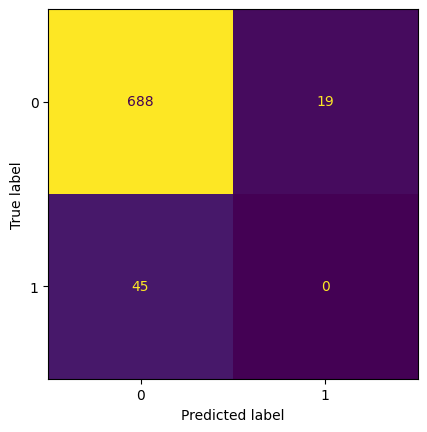

In [151]:
conf = ConfusionMatrixDisplay(mtx)
conf.plot(colorbar=False, );

## F1 Score

**What is an F1 Score?**

> The F1 score is a measure of a model's accuracy that combines the precision and recall metrics into a single score. It takes into account both false positives and false negatives, making it a useful metric for evaluating models that deal with imbalanced classes.

- $tp$ - True Positives
- $tn$ - True Negatives
- $fp$ - False Positives
- $fn$ - False Negatives

**F1 Formula**

$f1 = \frac{tp}{tp + \frac{1}{2}(fp + fn)}$

Here are a few examples of how the F1 score is calculated:

In a binary classification problem, suppose a model classified 100 samples, 90 of which were actual positives and 10 were actual negatives. Of these, the model correctly predicted 85 of the positives and 5 of the negatives. The precision and recall scores are:

precision = 85 / (85 + 5) = 0.944 recall = 85 / 90 = 0.944

The F1 score is calculated as 2 * precision * recall / (precision + recall) = 0.944.

In [68]:
m.f1_score(df.class_truth, df.class_pred, pos_label='Alternaria spp.')

0.9555555555555555

## Accuracy

In [63]:
m.accuracy_score(df.class_truth, df.class_pred)

0.9148936170212766

## Precision

In [65]:
df.class_truth.value_counts(), df.class_pred.value_counts()

(Alternaria spp.    707
 Undetected          45
 Name: class_truth, dtype: int64,
 Alternaria spp.    733
 Undetected          19
 Name: class_pred, dtype: int64)

In [66]:
m.precision_score(df.class_truth, df.class_pred, pos_label='Alternaria spp.')

0.9386084583901774

## Recall/Sensitivity

In [ ]:
m.recall_score(df.class_truth, df.class_pred, pos_label='Alternaria spp.')

0.9731258840169731

## Specificity

In [71]:
mtx[0][0] / (mtx[0][1] + mtx[1][1])

36.21052631578947

In [72]:
df.shape

(752, 3)

In [76]:
len(predicted)

752